<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#MySQL-Database-Functions" data-toc-modified-id="MySQL-Database-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>MySQL Database Functions</a></span><ul class="toc-item"><li><span><a href="#Create-YouTube-Database" data-toc-modified-id="Create-YouTube-Database-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Create YouTube Database</a></span></li><li><span><a href="#Create-Channels-Table" data-toc-modified-id="Create-Channels-Table-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Create Channels Table</a></span></li><li><span><a href="#Insert-Data-into-Channels-Table" data-toc-modified-id="Insert-Data-into-Channels-Table-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Insert Data into Channels Table</a></span></li></ul></li><li><span><a href="#API-Functions" data-toc-modified-id="API-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>API Functions</a></span></li><li><span><a href="#Executing-our-Functions" data-toc-modified-id="Executing-our-Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Executing our Functions</a></span><ul class="toc-item"><li><span><a href="#YouTube-Search---Store-results-in-channel_ids" data-toc-modified-id="YouTube-Search---Store-results-in-channel_ids-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>YouTube Search - Store results in channel_ids</a></span></li></ul></li><li><span><a href="#Data-Manipulation-for-csv" data-toc-modified-id="Data-Manipulation-for-csv-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Manipulation for csv</a></span><ul class="toc-item"><li><span><a href="#Cleaning-Functions" data-toc-modified-id="Cleaning-Functions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Cleaning Functions</a></span></li><li><span><a href="#Execute-cleaning" data-toc-modified-id="Execute-cleaning-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Execute cleaning</a></span></li></ul></li><li><span><a href="#Statistical-Analysis-Exploration" data-toc-modified-id="Statistical-Analysis-Exploration-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Statistical Analysis Exploration</a></span><ul class="toc-item"><li><span><a href="#Find-out-which-countries-appear-the-most-times-in-our-list" data-toc-modified-id="Find-out-which-countries-appear-the-most-times-in-our-list-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Find out which countries appear the most times in our list</a></span></li><li><span><a href="#ANOVA" data-toc-modified-id="ANOVA-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>ANOVA</a></span><ul class="toc-item"><li><span><a href="#View-Count" data-toc-modified-id="View-Count-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>View Count</a></span></li><li><span><a href="#Subscriber-count" data-toc-modified-id="Subscriber-count-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Subscriber count</a></span></li><li><span><a href="#Video-count" data-toc-modified-id="Video-count-5.2.3"><span class="toc-item-num">5.2.3&nbsp;&nbsp;</span>Video count</a></span></li></ul></li></ul></li><li><span><a href="#Data-Visualization" data-toc-modified-id="Data-Visualization-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Data Visualization</a></span></li></ul></div>

In [253]:
import mysql.connector 
import config
import requests
import time  # This is just to be able to make multiple calls to the API in spaced out time intervals
import string # For the remove_special_chars function
import pandas as pd

In [ ]:
# cursor.close()
# cnx.close()

# MySQL Database Functions

## Create YouTube Database

In [338]:
len(channels_data)

5

In [ ]:
cnx = mysql.connector.connect(
    host = marco_config.host,
    user = marco_config.user,
    passwd = marco_config.password
)
cursor = cnx.cursor()

In [ ]:
from mysql.connector import errorcode

db_name = 'youtube'

def create_database(cursor, database):
    try:
        cursor.execute(
            f"CREATE DATABASE {database} DEFAULT CHARACTER SET 'utf8'")
    except mysql.connector.Error as err:
        print("Failed creating database: {}".format(err))
        exit(1)

try:
    cursor.execute("USE {}".format(db_name))
except mysql.connector.Error as err:
    print("Database {} does not exists.".format(db_name))
    if err.errno == errorcode.ER_BAD_DB_ERROR:
        create_database(cursor, db_name)
        print("Database {} created successfully.".format(db_name))
        cnx.database = db_name
    else:
        print(err)
        exit(1)

## Create Channels Table

In [ ]:
create_query = """
CREATE TABLE channels (
    channel_id varchar(20) NOT NULL UNIQUE, 
    channel_title varchar(60) NOT NULL UNIQUE, 
    creation_date datetime NOT NULL, 
    country varchar(20) NOT NULL, 
    view_count int NOT NULL,
    comment_count int,
    subscriber_count int NOT NULL,
    video_count int NOT NULL,
    genres varchar(50)
    );

"""
cursor.execute(create_query)



## Insert Data into Channels Table

In [ ]:
def insert_channel(parsed_channel_data):
    """
    Inserts parsed_channel_data into the channels table in the youtube MySQL database.
    """
    
    channel_tuple = (parsed_channel_data['channel_id'],
                     parsed_channel_data['channel_title'],
                     parsed_channel_data['creation_date'],
                     parsed_channel_data['country'],
                     parsed_channel_data['view_count'],
                     parsed_channel_data['comment_count'],
                     parsed_channel_data['subscriber_count'],
                     parsed_channel_data['video_count'],
                     parsed_channel_data['genres'])
    
    insert_statement = """
        INSERT INTO channels 
            (channel_id, 
            channel_title, 
            creation_date, 
            country, 
            view_count,
            comment_count,
            subscriber_count,
            video_count,
            genres
            )
        VALUES
            (%s, %s, %s, 
             %s, %s, %s,
             %s, %s, %s)"
        """
    cursor.executemany(insert_statement,channel_tuple)
    cnx.commit()

# API Functions

In [559]:
def remove_special_chars(word):
    """
    Helper function for youtube_search
    
    Returns a string that removes any characters from word that are not 
    0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c
    
    Param word: [str] name of a youtube channel that may or may not include special characters.
    """
    assert type(word) == str, 'The input was not a string'
    
    new_word = ''
    for index in range(len(word)):
        if word[index] in string.printable:
            new_word += word[index]
    return new_word

def youtube_search(api_key, channel_name):
    """
    Returns a dictionary with the requested YouTube search information.
    
    Param api_key: [str] The YouTube Data API key.
    Param channel_name: [str] The channel name you want to find the channel id of.
    """
    assert type(channel_name) == str, 'The channel_name is not a string'
    
    keyword = remove_special_chars(channel_name)
    part='part=id,snippet'
    keyword=f'q={keyword}'
    
    url = f'https://www.googleapis.com/youtube/v3/search?key={api_key}&{part}&{keyword}'
    
    response = requests.get(url)
    
    return response.json()

def parse_search_data(results, channel_name):
    """
    Returns a channel ID and for the given YouTube search result. If no channel matching the same name as
    channel_name (which is the exact same input in youtube_search, and which we assume is the correct name),
    we return None. 
    
    Param channel_name: [str] exact channel name. should be the same as the keyword parameter for youtube_search.
                        This is because we only want to store the id if it corresponds to a channel we actually
                        care about, and not some random channel we accidentally pull.
    Param results: [dict] The output of a YouTube API search.
    """
    
    for index in range(len(results['items'])):
        if (results['items'][index]['id']['kind'] == 'youtube#channel') and (results['items'][index]['snippet']['channelTitle'] == channel_name):
            return results['items'][index]['id']['channelId'] #, results['items'][index]['snippet']['channelTitle']
    return None
    
def get_channels_data(api_key, channel_ids):
    """
    Returns a dictionary with the requested YouTube channel information. This is limited to 50 results, 
    so we can only give it 50 ids at once.
    
    Param api_key: [str] The YouTube Data API key.
    
    Param channel_id: [list of strs] List with 1 <= len <= 50 channel ids that we want to get information for
    """
    
    part = 'part=snippet,statistics,topicDetails'
    
    # According to the documentation, the ids must be a "comma-separated list of the YouTube channel 
    # ID(s) for the resource(s) that are being retrieved". Thus, we must use ','.join on our list of 
    # channel ids.
    
    ids = f'id={",".join(channel_ids)}' 
    
    url = f'https://www.googleapis.com/youtube/v3/channels?key={api_key}&{part}&{ids}'
    
    response = requests.get(url)
    
    return response.json()

def parse_channels_data(channels_data):
    
    """
    Returns: A list of parsed channel data from the raw YouTube API Channel call.
    
    Param channels_data: [Dict] The JSON output of the YouTube Channel API call. Accounts for the possibility of
    having 1 - 50 channel entries.
    
    Note: channel_results['items'] leads you to a list that contains a single dictionary, 
          which is why we limit to [0]. In theory, it should be a list of dictionaries, 
          but since we limit our search to a single channel, the list is of length 1
    """
    parsed_channels_data = []
    
    for index in range(len(channels_data['items'])):
    
        parsed_channel_data = {}

        # channel ID
        parsed_channel_data['channel_id'] = channels_data['items'][index]['id'] 

        # channel name
        parsed_channel_data['channel_title'] = channels_data['items'][index]['snippet']['title']

        # date created
        try:
            parsed_channel_data['creation_date'] = channels_data['items'][index]['snippet']['publishedAt'] 

        except:
            parsed_channel_data['creation_date'] = None

        # where the user is located
        try:
            parsed_channel_data['country'] = channels_data['items'][index]['snippet']['country'] 

        except:

            parsed_channel_data['country'] = None

        # total views on their videos
        parsed_channel_data['view_count'] = channels_data['items'][index]['statistics']['viewCount']

        # number of comments for the channel
        parsed_channel_data['comment_count'] = channels_data['items'][index]['statistics']['commentCount'] 

        # number of subscribers to 3 sig figs
        parsed_channel_data['subscriber_count'] = channels_data['items'][index]['statistics']['subscriberCount'] 

        # number of videos uploaded to the channel
        parsed_channel_data['video_count'] = channels_data['items'][index]['statistics']['videoCount'] 

        # genres based on the wikipedia links that describe the 'categories' of a channel. Had to massage
        # a little here because we want to put wikipedia URLs into nicely formatted genre strings.
        # Not sure if every channel has these, so threw in a try-except to assign the value to None if necessary.
        try:
            wiki_links = channels_data['items'][index]['topicDetails']['topicCategories']
            parsed_channel_data['genres'] = [link[link.find('wiki/')+5:].replace('_', ' ').title() for link in wiki_links]

        except:
            parsed_channel_data['genres'] = None
        
        parsed_channels_data.append(parsed_channel_data)
    
    return parsed_channels_data

# Executing our Functions

In [23]:
marco_key = config.marco_key 
melissa_key = config.melissa_key 
third_key = config.third_key 

# Loading the channel names doc
df = pd.read_csv('Workbook1.csv',encoding = "ISO-8859-1")
df['Channels'] = df['Channels'].str.rstrip('æ')
channel_names = df.Channels.tolist()

## YouTube Search - Store results in channel_ids

In [564]:
# Loop through list of channel names

for channel_name in channel_names[366:]:
    search_results = youtube_search(melissa_key, channel_name)
    channel_id = parse_search_data(search_results, channel_name)
    if channel_id:
        channel_ids.append(channel_id)
    time.sleep(0.25) # wait 0.25 seconds before making the next call, just in case ... 

   

KeyError: 'items'

In [569]:
# No. of new ids obtained 11.13 morning
channel_ids[453]

'UCVnu0ZtcaY9bpJgdxAaqagA'

In [566]:
new_parsed_channels_data = []

In [570]:
total_len = len(channel_ids)
start_index = 279
end_index = start_index + 50 #Can only search 50 ids at once

In [571]:
# Automating the process of obtaining and parsing 50 channels' data at once.

while start_index < total_len:
    if end_index > total_len:
        end_index = total_len - 1
    channels_data = get_channels_data(third_key, channel_ids[start_index:end_index])
    new_parsed_channels_data.extend(parse_channels_data(channels_data))
    start_index += 50
    end_index += 50

In [620]:

parsed_channels_data.extend(new_parsed_channels_data)

# Data Manipulation for csv

## Cleaning Functions

In [611]:
def dedup(df):
    """
    This function deletes any duplicate rows in our dataframe based on channel id. Use cautiously.
    
    Param: channel dataframe to deduplicate
    """
    # No. of duplicates (id count - unique id count)
    no_dups = df.channel_id.describe()[0] - df.channel_id.describe()[1]
    
    for loop in range(no_dups):
        id_to_del = df.channel_id.describe().top
        index_to_del = df[df['channel_id'] == id_to_del].reset_index().iloc[1]['index']
        df.drop(index_to_del,inplace=True)

## Execute cleaning

In [622]:
channels_df = pd.DataFrame(parsed_channels_data)
dedup(channels_df)
channels_df.channel_id.describe() # Confirm only unique rows

count                          403
unique                         403
top       UCgc00bfF_PvO_2AvqJZHXFg
freq                             1
Name: channel_id, dtype: object

In [626]:
channels_df[channels_df['subscriber_count'] == '0']

,channel_id,channel_title,creation_date,country,view_count,comment_count,subscriber_count,video_count,genres
325,UC5nc_ZtjKW1htCVZVRxlQAQ,MrSuicideSheep,2010-04-09T15:30:04.000Z,CA,5170264492,0,0,2438,"[Pop Music, Music, Electronic Music, Independe..."


In [624]:
channels_df.drop([12, 33, 41, 229,229,349,399],inplace=True)

In [627]:
channels_df.to_csv("channel_set_final.csv")

# Statistical Analysis Exploration

In [780]:
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password
)
cursor = cnx.cursor()

$$H_0: \text{All countries are equally likely to receive a given number of view counts} $$

$$H_1: \text{All countries are not equally likely to receive a given number of view counts}$$


## Find out which countries appear the most times in our list

In [781]:
cursor.execute("""
               SELECT
                 country,
                 COUNT(country),
                 AVG(view_count),
                 AVG(subscriber_count),
                 AVG(video_count)
               FROM
                 youtube.channels
               GROUP BY
                 country
               HAVING
                 COUNT(country) > 5
               ORDER BY
                 AVG(view_count) DESC
                """)

country_df = pd.DataFrame(cursor.fetchall())
country_df.columns = [x[0] for x in cursor.description]

In [782]:
def full_country_name(initials):
    """
    Returns full country name for top 4 countries.
    
    Param initials: ['str'] Series value in a DF that is the initials of a country.
    """
    if initials == 'IN':
        return 'India'
    if initials == 'US':
        return 'United States'
    if initials == 'BR':
        return 'Brazil'
    if initials == 'Null':
        return 'N/A'


In [783]:
# Find top four countries - Ones with most number of channels in this list

country_df.sort_values(by='COUNT(country)',ascending=False)[0:4]

,country,COUNT(country),AVG(view_count),AVG(subscriber_count),AVG(video_count)
4,Null,119,5589932740.0336,18400000.0588,3943.6975
2,US,109,6494191861.2018,18093577.9817,2076.5046
1,IN,41,9743576450.1951,21560975.6098,15910.2927
5,BR,30,5018424049.0667,16636666.6667,1654.1000



Now that we know the top countries, we can make a DataFrame that includes just those and clean from there.


In [784]:
cursor.execute("""
               SELECT
                 channel_title,
                 country,
                 view_count,
                 subscriber_count,
                 video_count
               FROM
                 youtube.channels
                """)

df = pd.DataFrame(cursor.fetchall())
df.columns = [x[0] for x in cursor.description]

In [785]:
top_countries = ['IN','US','BR','Null']

In [786]:
# Top countries df (countries from top 273 YT channels that have >5 channels in the list)
tc_df = df.loc[df['country'].isin(top_countries)].sort_values(by='view_count',ascending=False)

# Change country names from initials to full names
tc_df['country_name'] = tc_df.country.map(lambda x: full_country_name(x))

In [787]:
tc_df.head()

,channel_title,country,view_count,subscriber_count,video_count,country_name
280,T-Series,IN,88630702566,118000000,14009,India
92,Cocomelon - Nursery Rhymes,US,43335002834,65100000,474,United States
271,SET India,IN,43125038812,59300000,33607,India
189,WWE,Null,37182753702,50800000,44501,N/A
169,Ryan's World,US,33702183780,22500000,1563,United States


## ANOVA

In [788]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

### View Count

In [789]:
anova_view_cnt = ols('view_count~country_name',data=tc_df).fit()
anova_view_cnt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             view_count   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     3.147
Date:                Fri, 15 Nov 2019   Prob (F-statistic):             0.0255
Time:                        12:32:31   Log-Likelihood:                -7237.8
No. Observations:                 299   AIC:                         1.448e+04
Df Residuals:                     295   BIC:                         1.450e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      5.018e+09   1.45e+09      3.464      0.001    2.17e+09    7.87e+09
country_name[T.India]          4.725e+09   1.91e+09      2.479      0.014    9.73e+08    8.48e+09
country_name[T.N/A]            5.715e+08   1.62e+09      0.353      0.725   -2.62e+09    3.76e+09
country_name[T.United States]  1.476e+09   1.64e+09      0.902      0.368   -1.74e+09     4.7e+09
==============================================================================
Omnibus:                      326.811   Durbin-Watson:                   0.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16785.148
Skew:                           4.602   Prob(JB):                         0.00
Kurtosis:                      38.533   Cond. No.                         7.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [790]:
view_cnt_anova_table = sm.stats.anova_lm(anova_view_cnt, type=2)
pd.DataFrame(view_cnt_anova_table)

,df,sum_sq,mean_sq,F,PR(>F)
country_name,3.0,5.943758e+20,1.981253e+20,3.146733,0.025464
Residual,295.0,1.857385e+22,6.296221e+19,NaN,NaN


$$P(F) = 0.025$$ 

$$\alpha = 0.5$$

$$ \therefore P(F) < \alpha \text{ and we reject the null hypothesis regarding view count.}$$

In [671]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

# Set up the data for comparison (creates a specialised object)
view_cnt_MultiComp = MultiComparison(tc_df['view_count'],
                            tc_df['country_name'])

# Show all pair-wise comparisons:

# Print the comparisons

view_cnt_df = pd.DataFrame(view_cnt_MultiComp.tukeyhsd().summary())
view_cnt_df.columns = view_cnt_df.iloc[0]
view_cnt_df = view_cnt_df.iloc[1:]
view_cnt_df

,group1,group2,meandiff,p-adj,lower,upper,reject
1,Brazil,India,4725152401.1285,0.0655,-200697155.2362,9651001957.4931,False
2,Brazil,N/A,571508690.9669,0.9,-3617039833.6681,4760057215.602,False
3,Brazil,United States,1475767812.1352,0.7792,-2751288649.1251,5702824273.3955,False
4,India,N/A,-4153643710.1615,0.0214,-7866422780.9027,-440864639.4203,True
5,India,United States,-3249384588.9933,0.1163,-7005552318.4209,506783140.4343,False
6,N/A,United States,904259121.1682,0.803,-1813964729.5987,3622482971.9351,False


We can only reject the null hypothesis that there exists no statistical difference in view counts between Indian channels and those reporting no country.

### Subscriber count

In [648]:
anova_sub_cnt = ols('subscriber_count~country_name',data=tc_df).fit()
anova_sub_cnt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       subscriber_count   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.241
Date:                Fri, 15 Nov 2019   Prob (F-statistic):              0.295
Time:                        10:05:54   Log-Likelihood:                -5287.7
No. Observations:                 299   AIC:                         1.058e+04
Df Residuals:                     295   BIC:                         1.060e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      1.664e+07   2.13e+06      7.809      0.000    1.24e+07    2.08e+07
country_name[T.India]          4.924e+06    2.8e+06      1.756      0.080   -5.93e+05    1.04e+07
country_name[T.N/A]            1.763e+06   2.38e+06      0.740      0.460   -2.93e+06    6.45e+06
country_name[T.United States]  1.457e+06   2.41e+06      0.606      0.545   -3.28e+06    6.19e+06
==============================================================================
Omnibus:                      297.045   Durbin-Watson:                   1.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8952.263
Skew:                           4.157   Prob(JB):                         0.00
Kurtosis:                      28.484   Cond. No.                         7.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [650]:
sub_cnt_anova_table = sm.stats.anova_lm(anova_sub_cnt, type=2)
pd.DataFrame(sub_cnt_anova_table)

,df,sum_sq,mean_sq,F,PR(>F)
country_name,3.0,5.069067e+14,1.689689e+14,1.240932,0.29504
Residual,295.0,4.016807e+16,1.361630e+14,NaN,NaN


$P(F) > \alpha = 0.5$ therefore we fail to reject the null hypothesis regarding subscriber count.

### Video count

In [791]:
video_cnt_anova = ols('video_count~country_name',data=tc_df).fit()
video_cnt_anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            video_count   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     7.063
Date:                Fri, 15 Nov 2019   Prob (F-statistic):           0.000134
Time:                        12:32:41   Log-Likelihood:                -3337.8
No. Observations:                 299   AIC:                             6684.
Df Residuals:                     295   BIC:                             6698.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      1654.1000   3135.440      0.528      0.598   -4516.566    7824.766
country_name[T.India]          1.426e+04   4126.062      3.455      0.001    6135.945    2.24e+04
country_name[T.N/A]            2289.5975   3508.473      0.653      0.515   -4615.211    9194.406
country_name[T.United States]   422.4046   3540.729      0.119      0.905   -6545.885    7390.694
==============================================================================
Omnibus:                      393.785   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26153.179
Skew:                           6.303   Prob(JB):                         0.00
Kurtosis:                      47.049   Cond. No.                         7.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [792]:
vid_cnt_anova_table = sm.stats.anova_lm(video_cnt_anova, type=2)
pd.DataFrame(vid_cnt_anova_table)

,df,sum_sq,mean_sq,F,PR(>F)
country_name,3.0,6.248908e+09,2.082969e+09,7.0626,0.000134
Residual,295.0,8.700421e+10,2.949295e+08,NaN,NaN


$$P(F) = 0.00013$$ 

$$\alpha = 0.5$$

$$ \therefore P(F) < \alpha \text{ and we reject the null hypothesis regarding video count.}$$

In [793]:
# Set up the data for comparison (creates a specialised object)
vid_cnt_MultiComp = MultiComparison(tc_df['video_count'],
                            tc_df['country_name'])

# Show all pair-wise comparisons:

# Print the comparisons

vid_cnt_df = pd.DataFrame(vid_cnt_MultiComp.tukeyhsd().summary())
vid_cnt_df.columns = vid_cnt_df.iloc[0]
vid_cnt_df = vid_cnt_df.iloc[1:]
vid_cnt_df

,group1,group2,meandiff,p-adj,lower,upper,reject
1,Brazil,India,14256.1927,0.0035,3595.1352,24917.2502,True
2,Brazil,N/A,2289.5975,0.9,-6775.7132,11354.9082,False
3,Brazil,United States,422.4046,0.9,-8726.2491,9571.0583,False
4,India,N/A,-11966.5952,0.001,-20002.1941,-3930.9963,True
5,India,United States,-13833.7881,0.001,-21963.2934,-5704.2828,True
6,N/A,United States,-1867.1929,0.8251,-7750.2676,4015.8818,False


We can thus reject the null hypothesis that there exists no statistical difference in video counts between Brazilian & Indian channels, Indian and N/A channels, and Indian and US channels.

# Data Visualization

In [759]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white',palette='vlag')
%matplotlib inline

In [733]:
# Create a df for only top 4 countries and average column values so 
# that we can visualize this data and make some sense of the Tukey's test

vis_df = country_df.sort_values(by='COUNT(country)',ascending=False)[:4]

# Add country names column based on initials to have full names for visualization

vis_df['country_name'] = vis_df.country.map(lambda x: full_country_name(x))

# Make sure aggregate columns are ints (only figured this out because it wouldn't let me plot "nonnumerical data")

vis_df['AVG(view_count)'] = vis_df['AVG(view_count)'].apply(lambda x: int(x))
vis_df['AVG(subscriber_count)'] = vis_df['AVG(subscriber_count)'].apply(lambda x: int(x))
vis_df['AVG(video_count)'] = vis_df['AVG(video_count)'].apply(lambda x: int(x))

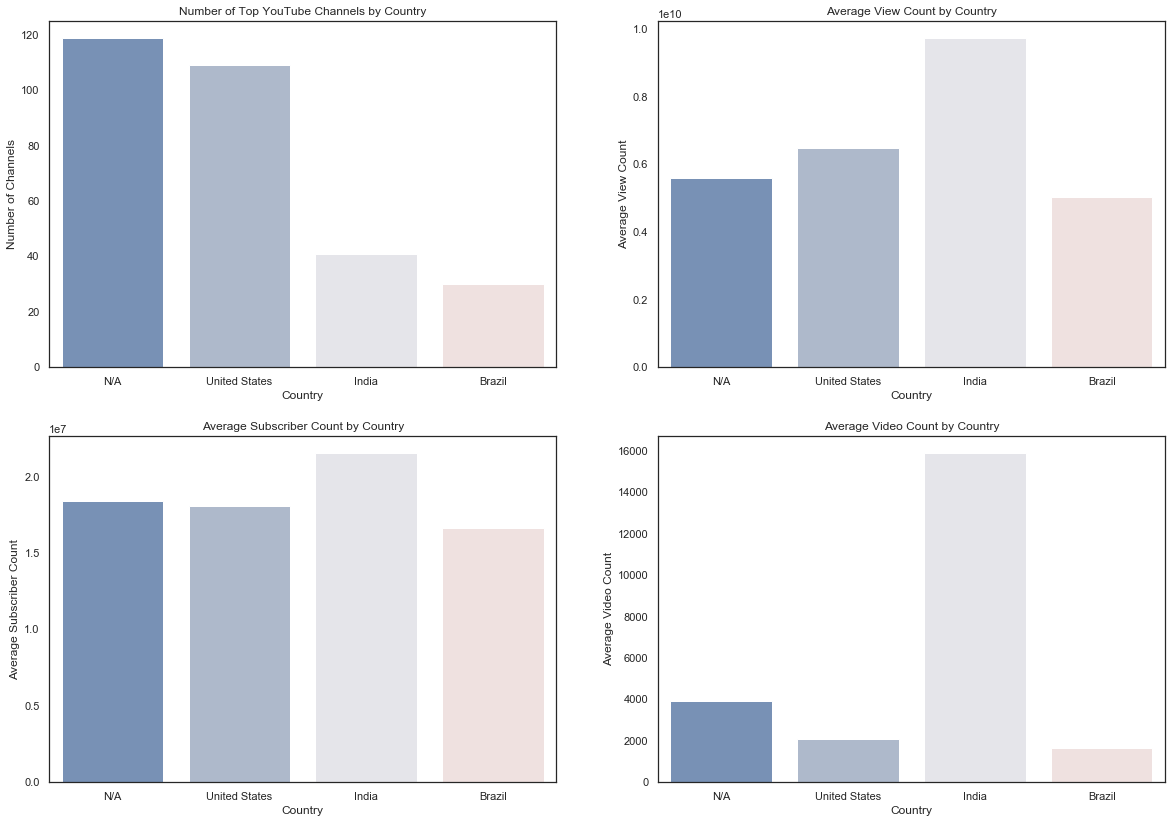

In [794]:
grid = (2,2) # Make a 2x2 axis grid to plot four plots in the same figure
fig = plt.figure(figsize=(20,14))
ax1 = plt.subplot2grid(grid, (0,0)) # First ax in position (0,0) (top left)
ax2 = plt.subplot2grid(grid, (0,1)) # Second ax in position (0,1) (top right)
ax3 = plt.subplot2grid(grid, (1,0)) # Third ax in position (1,0) (bottom left)
ax4 = plt.subplot2grid(grid, (1,1)) # Fourth ax in position (1,1) (bottom right)

sns.barplot(x=vis_df['country_name'],
            y=vis_df['COUNT(country)'],
            ax=ax1);

ax1.set_title('Number of Top YouTube Channels by Country');
ax1.set_xlabel('Country'), ax1.set_ylabel('Number of Channels');

sns.barplot(x=vis_df['country_name'],
            y=vis_df['AVG(view_count)'],
            ax=ax2)

ax2.set_title('Average View Count by Country');
ax2.set_xlabel('Country'), ax2.set_ylabel('Average View Count');

sns.barplot(x=vis_df['country_name'],
            y=vis_df['AVG(subscriber_count)'],
            ax=ax3);

ax3.set_title('Average Subscriber Count by Country');
ax3.set_xlabel('Country'), ax3.set_ylabel('Average Subscriber Count');



sns.barplot(x=vis_df['country_name'],
            y=vis_df['AVG(video_count)'],
            ax=ax4);

ax4.set_title('Average Video Count by Country');
ax4.set_xlabel('Country'), ax4.set_ylabel('Average Video Count');

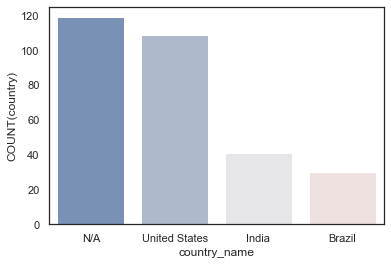

In [765]:
sns.barplot(x=vis_df['country_name'],
            y=vis_df['COUNT(country)'])

In [419]:
in_df = tc_df[tc_df['country'] == 'IN']
us_df = tc_df[tc_df['country'] == 'US']
br_df = tc_df[tc_df['country'] == 'BR']
null_df = tc_df[tc_df['country'] == 'Null']

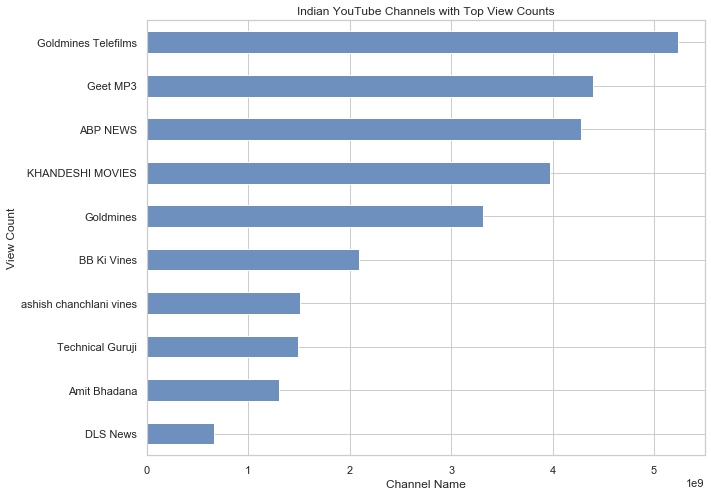

In [555]:
# India View Counts

fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot()

in_df.sort_values(by='view_count')[:10].plot.barh(x='channel_title',y='view_count',ax=ax1, legend=False)
# in_df.sort_values(by='view_count',ascending=False)[:10].plot.barh(x='channel_title',y='video_count',ax=ax1, legend=False,color='b',alpha=0.7)
ax1.set_title('Indian YouTube Channels with Top View Counts')
ax1.set_xlabel('Channel Name'), ax1.set_ylabel('View Count');

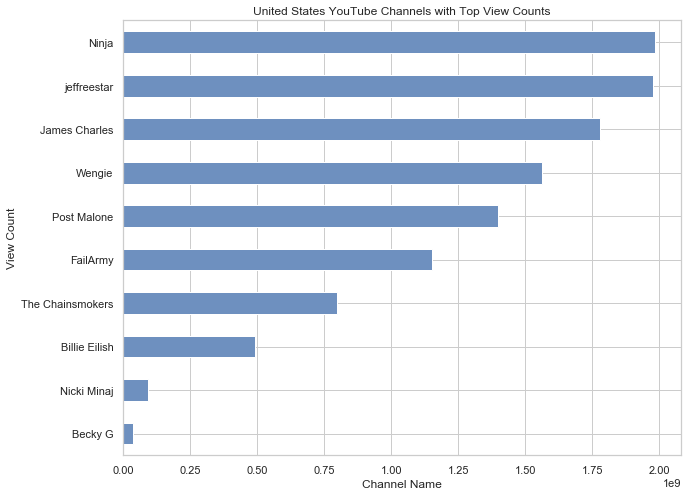

In [556]:
# US View Counts

fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot()

us_df.sort_values(by='view_count')[:10].plot.barh(x='channel_title',y='view_count',ax=ax1, legend=False)
ax1.set_title('United States YouTube Channels with Top View Counts')
ax1.set_xlabel('Channel Name'), ax1.set_ylabel('View Count');

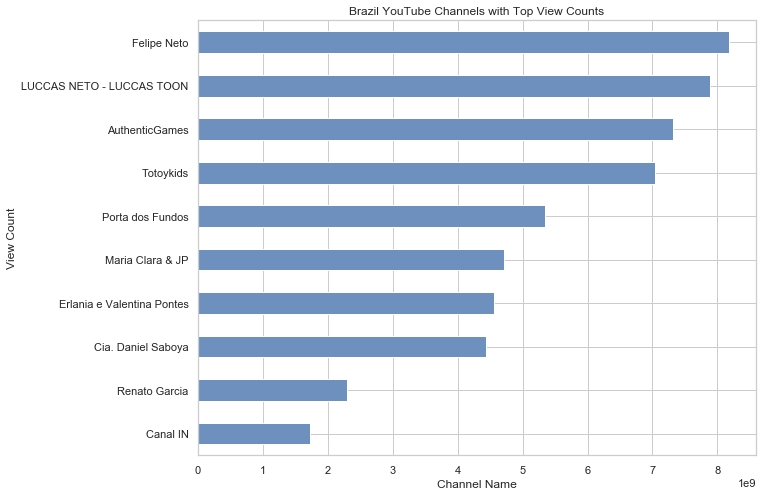

In [557]:
# Brazil View Counts

fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot()

br_df.sort_values(by='view_count')[:10].plot.barh(x='channel_title',y='view_count',ax=ax1, legend=False)
ax1.set_title('Brazil YouTube Channels with Top View Counts')
ax1.set_xlabel('Channel Name'), ax1.set_ylabel('View Count');

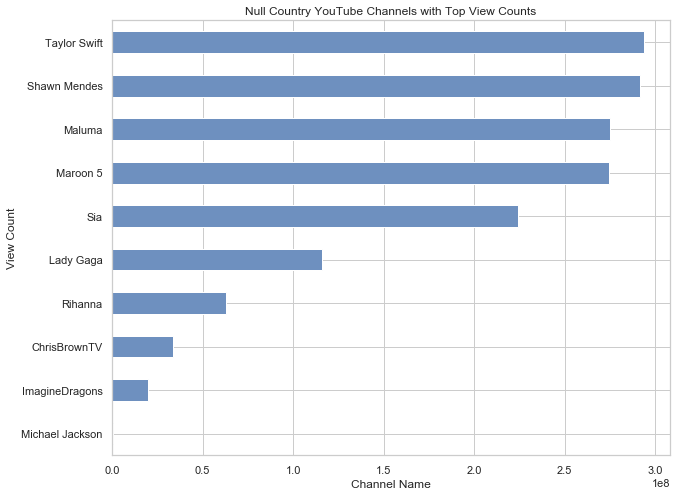

In [558]:
# Null View Counts

fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot()

null_df.sort_values(by='view_count').iloc[:10].plot.barh(x='channel_title',y='view_count',ax=ax1, legend=False)
ax1.set_title('Null Country YouTube Channels with Top View Counts')
ax1.set_xlabel('Channel Name'), ax1.set_ylabel('View Count');